# Fully Connected Neural Network

In [454]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [455]:
import pandas as pd
import numpy as np
import os
import glob

In [456]:
X = np.empty((420,2))
parent_folder_path = '/Users/nimitt/Documents/SRIP/SemiconductorFabricationGAA/Data_GAA/CSV_files'
folders = glob.glob(os.path.join(parent_folder_path, '*'))
for i in range(len(folders)):
    files = glob.glob(os.path.join(folders[i], '*'))
    files.sort()

    for j in range(5):
       
        path = files[j]
        path_break = path.split('/')
        features = np.array(list(map(float,path_break[-1][7:-4].split('_'))))
        X[5*i+j] = features

In [457]:
Y = np.empty((420,20,40))
parent_folder_path = '/Users/nimitt/Documents/SRIP/SemiconductorFabricationGAA/Data_GAA/CSV_files'
folders = glob.glob(os.path.join(parent_folder_path, '*'))
for i in range(len(folders)):
    files = glob.glob(os.path.join(folders[i], '*'))
    files.sort()

    for j in range(len(files)):
        path = files[j]
        data = pd.read_csv(path)
        for k in range(20):
            Y[5*i+j][k] = data[' Metrology_Out'][40*k:40*(k+1)] - 0.008

In [458]:
Y = Y[:, 2:-2, np.r_[0:10]]
Y = Y[:,::1,::1]


In [459]:
Y.shape

(420, 16, 10)

In [460]:
Y = Y.reshape(420,-1)

In [461]:
Y.shape

(420, 160)

In [462]:
C = np.empty((420,3,20,40))
parent_folder_path = '/Users/nimitt/Documents/SRIP/SemiconductorFabricationGAA/Data_GAA/CSV_files'
folders = glob.glob(os.path.join(parent_folder_path, '*'))
for i in range(len(folders)):
    files = glob.glob(os.path.join(folders[i], '*'))
    files.sort()

    for j in range(len(files)):
        path = files[j]
        data = pd.read_csv(path)
        for k in range(20):
            C[5*i+j][0][k] = data['x1'][40*k:40*(k+1)]
            C[5*i+j][1][k] = data[' y1'][40*k:40*(k+1)]
            C[5*i+j][2][k] = data[' z1'][40*k:40*(k+1)]

In [463]:
C = C[:,:, 2:-2, np.r_[0:10]]


In [464]:
C = C[:,:,::1,::1]

In [465]:
C = C.reshape(420,3, -1)

In [466]:
C.shape

(420, 3, 160)

In [467]:
X.shape

(420, 2)

In [468]:
X_fnn = X.copy()
Y_fnn = Y.copy()

In [469]:
X_scaler = MinMaxScaler()
X_fnn = X_scaler.fit_transform(X_fnn)

In [470]:
Y_scaler = MinMaxScaler()
Y_fnn = Y_scaler.fit_transform(Y_fnn)

In [471]:
Y_fnn.shape

(420, 160)

In [472]:
C.shape

(420, 3, 160)

In [473]:
X_train_, X_test_, Y_train, Y_test, C_train, C_test = train_test_split(X_fnn, Y_fnn,C,train_size = 0.8)

# Tensorification

C_train = C_train.reshape(-1,3)
Y_train = Y_train.reshape(-1,1)

X_new = np.tile(X_train_[:, np.newaxis, :], (1, 160, 1))
X_new = X_new.reshape(-1,2)
X_train = np.hstack([X_new,C_train])

C_test = C_test.reshape(-1,3)
Y_test = Y_test.reshape(-1,1)

X_new = np.tile(X_test_[:, np.newaxis, :], (1, 160, 1))
X_new = X_new.reshape(-1,2)
X_test = np.hstack([X_new,C_test])

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)


In [474]:
class FNN2(nn.Module):
    def __init__(self):
        super(FNN2, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)      
        return x
    
model2 = FNN2()
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

In [475]:

train_loss = []
test_loss = []
def train(model, criterion, optimizer, num_epochs):
   
    for epoch in range(num_epochs):
            
            
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        with torch.no_grad():
            test_loss.append(criterion(model(X_test),Y_test))
            
        if (epoch+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]], Loss: {loss.item():.7f}')

In [476]:
with torch.no_grad():
    out = model2(X_train)
    loss = criterion(out,Y_train)
    print(loss)

tensor(0.3115)


In [477]:
train(model2, criterion,optimizer,1000)

Epoch [1/1000]], Loss: 0.3114889
Epoch [2/1000]], Loss: 0.1225729
Epoch [3/1000]], Loss: 2.2341769
Epoch [4/1000]], Loss: 0.1159504
Epoch [5/1000]], Loss: 0.2167174
Epoch [6/1000]], Loss: 0.2646708
Epoch [7/1000]], Loss: 0.2712724
Epoch [8/1000]], Loss: 0.2686624
Epoch [9/1000]], Loss: 0.2620498
Epoch [10/1000]], Loss: 0.2512253
Epoch [11/1000]], Loss: 0.2350060
Epoch [12/1000]], Loss: 0.2129864
Epoch [13/1000]], Loss: 0.1841511
Epoch [14/1000]], Loss: 0.1507532
Epoch [15/1000]], Loss: 0.1252511
Epoch [16/1000]], Loss: 0.1415638
Epoch [17/1000]], Loss: 0.1422020
Epoch [18/1000]], Loss: 0.1214763
Epoch [19/1000]], Loss: 0.1224742
Epoch [20/1000]], Loss: 0.1312451
Epoch [21/1000]], Loss: 0.1246348
Epoch [22/1000]], Loss: 0.1164133
Epoch [23/1000]], Loss: 0.1162787
Epoch [24/1000]], Loss: 0.1189940
Epoch [25/1000]], Loss: 0.1170107
Epoch [26/1000]], Loss: 0.1108653
Epoch [27/1000]], Loss: 0.1067132
Epoch [28/1000]], Loss: 0.1053475
Epoch [29/1000]], Loss: 0.1024333
Epoch [30/1000]], Loss:

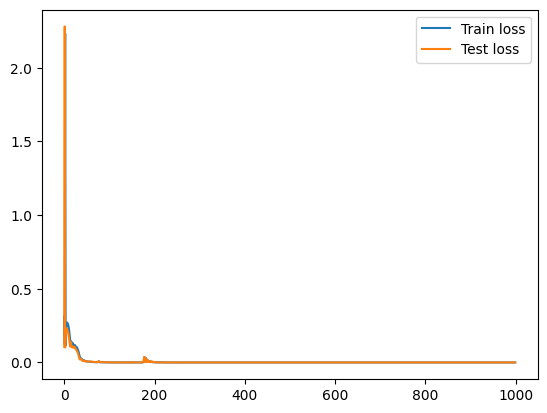

In [478]:
sr = np.arange(len(train_loss))
plt.plot(sr, train_loss,label = 'Train loss')
plt.plot(sr,test_loss, label = 'Test loss')
plt.legend()

In [479]:
Y_train=Y_train.reshape(-1,160)

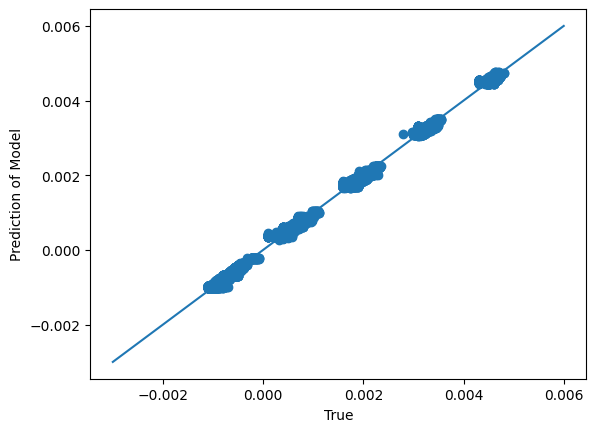

In [480]:
with torch.no_grad():
    y_hat = model2((X_train))
    y_hat = y_hat.reshape(-1,160)
    y_hat = Y_scaler.inverse_transform(y_hat)

plt.scatter(Y_scaler.inverse_transform(Y_train).reshape(-1,1),y_hat.reshape(-1,1))
plt.plot([-0.003,0.006],[-0.003,0.006])
plt.xlabel('True')
plt.ylabel('Prediction of Model')
plt.show()


In [481]:


X_ = np.tile(X_fnn[:, np.newaxis, :], (1, 160, 1))
X_ = X_.reshape(-1,2)
X_new = np.hstack([X_,C.reshape(-1,3)])

X_new = torch.tensor(X_new, dtype=torch.float32)
Y_new = torch.tensor(Y_fnn, dtype=torch.float32)

In [482]:
X_new.shape

torch.Size([67200, 5])

In [483]:
Y_new.shape

torch.Size([420, 160])

In [484]:
y_hat.shape

(336, 160)

In [485]:
model2((X_new)).shape

torch.Size([67200, 1])

ClFlux =  0.00232 , Time =  1.2931


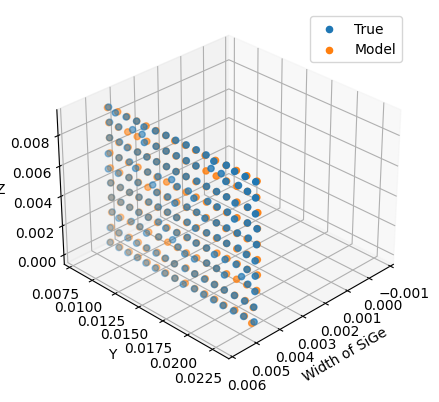

ClFlux =  0.00054 , Time =  5.5556


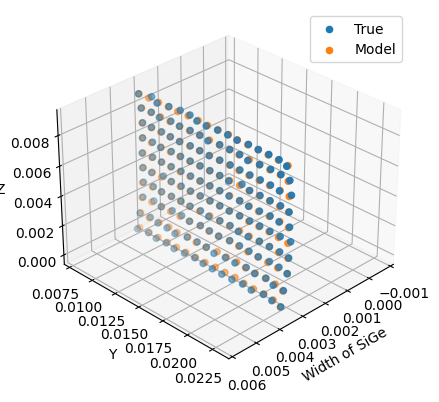

ClFlux =  0.00293 , Time =  4.0956


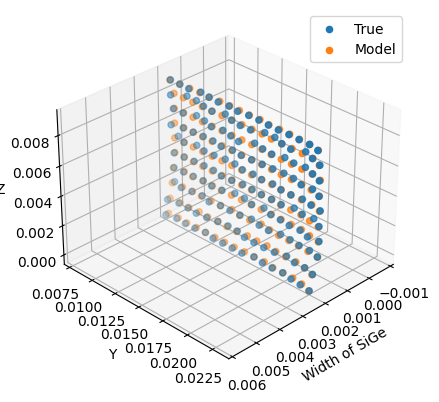

ClFlux =  0.00111 , Time =  2.7027


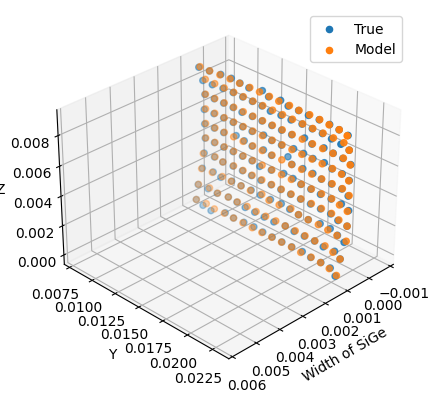

ClFlux =  0.00142 , Time =  2.1127


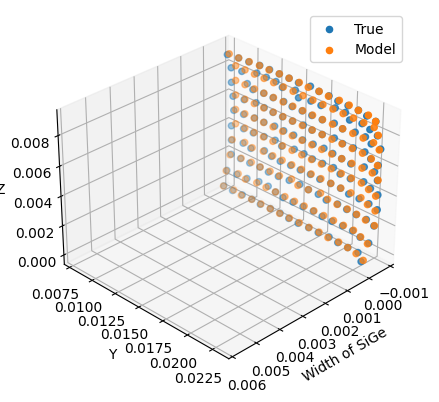

In [486]:
with torch.no_grad():
    y_hat = Y_scaler.inverse_transform(model2((X_new)).reshape(-1,160))

for j in range(5):
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    print('ClFlux = ',X[24*j][0],', Time = ',X[24*j][1])
    
    y = C[j][1]
    z = C[j][2]
    x = Y_scaler.inverse_transform(Y_new)[j]
    x_model = y_hat[j]
    ax.scatter3D(x, y, z,label = 'True')
    ax.scatter3D(x_model, y, z,label = 'Model')
    ax.set_xlim(-0.001, 0.006)
    ax.set_xlabel('Width of SiGe')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=30, azim=45)  

   
    plt.legend()
    plt.show()

    # plt.scatter(x,x_model)
    # x_0 = min(min(x),min(x_model))
    # x_1 = max(max(x),max(x_model))
    # plt.plot([x_0,x_1],[x_0,x_1])